# Klotz Curve
Inlate a geometry to a pressure using different material models, and compare with the Klotz curve. Parameters used in this demo are based on the paper by Hadjicharalambous et. al.


> Klotz, Stefan, et al. “Single-beat estimation of end-diastolic pressure-volume relationship: a novel method with potential for noninvasive application.” American Journal of Physiology-Heart and Circulatory Physiology 291.1 (2006): H403-H412.

> Hadjicharalambous, Myrianthi, et al. “Analysis of passive cardiac constitutive laws for parameter estimation using 3D tagged MRI.” Biomechanics and modeling in mechanobiology 14.4 (2015): 807-828.

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import dolfin
import pulse

geometry = pulse.HeartGeometry.from_file(pulse.mesh_paths['simple_ellipsoid'])
geometry.mesh.coordinates()[:] *= 3.15
ED_pressure = 1.6  # kPa

2019-05-22 07:44:44,228 - pulse.geometry_utils - INFO - 
Load mesh from h5


In [2]:
def setup_material(material_model):
    """
    Choose parameters based on

    Hadjicharalambous, Myrianthi, et al. "Analysis of passive
    cardiac constitutive laws for parameter estimation using 3D
    tagged MRI." Biomechanics and modeling in mechanobiology 14.4
    (2015): 807-828.

    These parameters did not really match the Klotz curve here.
    Perhaps they did some more tuning?

    """
    if material_model == "guccione":

        matparams = pulse.Guccione.default_parameters()
        matparams["C"] = 0.18  # kPa
        matparams["bf"] = 27.75
        matparams["bt"] = 5.37
        matparams["bfs"] = 2.445
        material = pulse.Guccione(parameters=matparams,
                                  f0=geometry.f0,
                                  s0=geometry.s0,
                                  n0=geometry.n0)

    elif material_model == "neo_hookean":

        matparams = pulse.NeoHookean.default_parameters()
        matparams["mu"] = 10.0  # kPa
        material = pulse.NeoHookean(parameters=matparams)

    elif material_model == "holzapfel_ogden":

        matparams = pulse.HolzapfelOgden.default_parameters()

        matparams["a"] = 4.0  # kPa
        matparams["a_f"] = 10.0  # kPa
        matparams["b"] = 5.0
        matparams["b_f"] = 5.0
        material = pulse.HolzapfelOgden(parameters=matparams,
                                        f0=geometry.f0,
                                        s0=geometry.s0,
                                        n0=geometry.n0)
    return material


In [3]:
def klotz_curve():
    """

    EDPVR based on Klotz curve

    Klotz, Stefan, et al. "Single-beat estimation of end-diastolic
    pressure-volume relationship: a novel method with potential for
    noninvasive application." American Journal of Physiology-Heart and
    Circulatory Physiology 291.1 (2006): H403-H412.

    """

    # Some point at the EDPVR line
    Vm = 148.663
    Pm = ED_pressure

    # Some constants
    An = 27.8
    Bn = 2.76

    # kpa to mmhg
    Pm = Pm * 760/101.325

    V0 = Vm * (0.6 - 0.006 * Pm)
    V30 = V0 + (Vm - V0) / (Pm/An)**(1.0/Bn)

    beta = math.log(Pm / 30.0) / math.log(Vm / V30)
    alpha = 30.0/V30**beta

    # Unloaded volume (not used here)
    # P_V0 = alpha * V0 ** beta

    vs = [V0]
    ps = [0.0]
    for p in np.linspace(1.0, 12.0):
        vi = (p / alpha) ** (1.0 / beta)
        vs.append(vi)
        ps.append(p * 101.325/760)  # Convert from mmhg to kPa

    return vs, ps

In [10]:
def fix_basal_plane(W):
    V = W if W.sub(0).num_sub_spaces() == 0 else W.sub(0)
    bc = dolfin.DirichletBC(V,
                            dolfin.Constant((0.0, 0.0, 0.0)),
                            geometry.ffun, geometry.markers["BASE"][0])
    return bc

dirichlet_bc = [fix_basal_plane]

lvp = dolfin.Constant(0.0)
lv_marker = geometry.markers['ENDO'][0]
lv_pressure = pulse.NeumannBC(traction=lvp,
                              marker=lv_marker, name='lv')
neumann_bc = [lv_pressure]

bcs = pulse.BoundaryConditions(dirichlet=dirichlet_bc,
                               neumann=neumann_bc)

P = {}
V = {}
for material_model in ["neo_hookean", "guccione", "holzapfel_ogden"]:

    material = setup_material(material_model)
    problem = pulse.MechanicsProblem(geometry, material, bcs)

    pressures = [0.0]
    volumes = [geometry.cavity_volume()]

    for p in np.linspace(0, ED_pressure, 10)[1:]:
        pulse.iterate.iterate(problem, lvp, p)

        pressures.append(p)
        volumes.append(geometry.cavity_volume(u=problem.state.split()[0]))
    P[material_model] = pressures
    V[material_model] = volumes
    
    # Reset pressure
    lvp.assign(dolfin.Constant(0.0))

2019-05-22 07:55:25,600 - pulse.iterate - INFO - Control: [0.0]
2019-05-22 07:55:25,601 - pulse.iterate - INFO - Target: [0.17777777777777778]
2019-05-22 07:55:25,602 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:25,603 - pulse.iterate - INFO - Maximum difference: 1.778e-01
2019-05-22 07:55:25,604 - pulse.iterate - INFO - Try new control
2019-05-22 07:55:25,604 - pulse.iterate - INFO - Current control: 0.036
2019-05-22 07:55:25,986 - pulse.iterate - INFO - 
SUCCESFULL STEP:
2019-05-22 07:55:25,987 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:25,988 - pulse.iterate - INFO - Maximum difference: 1.422e-01
2019-05-22 07:55:25,988 - pulse.iterate - INFO - Adapt step size. New step size: 0.053
2019-05-22 07:55:25,989 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:25,990 - pulse.iterate - INFO - Maximum difference: 1.422e-01
2019-05-22 07:55:25,991 - pulse.iterate - INFO - Try new control
2019-05-22 07:55:25,991 - pulse.iterate - 

2019-05-22 07:55:29,643 - pulse.iterate - INFO - Maximum difference: 1.422e-01
2019-05-22 07:55:29,644 - pulse.iterate - INFO - Adapt step size. New step size: 0.053
2019-05-22 07:55:29,646 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:29,646 - pulse.iterate - INFO - Maximum difference: 1.422e-01
2019-05-22 07:55:29,647 - pulse.iterate - INFO - Try new control
2019-05-22 07:55:29,648 - pulse.iterate - INFO - Current control: 0.622
2019-05-22 07:55:29,955 - pulse.iterate - INFO - 
SUCCESFULL STEP:
2019-05-22 07:55:29,956 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:29,956 - pulse.iterate - INFO - Maximum difference: 8.889e-02
2019-05-22 07:55:29,957 - pulse.iterate - INFO - Adapt step size. New step size: 0.080
2019-05-22 07:55:29,958 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:29,959 - pulse.iterate - INFO - Maximum difference: 8.889e-02
2019-05-22 07:55:29,960 - pulse.iterate - INFO - Try new control
2019-05-22 07:55:29

2019-05-22 07:55:33,893 - pulse.iterate - INFO - Maximum difference: 8.889e-02
2019-05-22 07:55:33,894 - pulse.iterate - INFO - Adapt step size. New step size: 0.080
2019-05-22 07:55:33,895 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:33,896 - pulse.iterate - INFO - Maximum difference: 8.889e-02
2019-05-22 07:55:33,896 - pulse.iterate - INFO - Try new control
2019-05-22 07:55:33,897 - pulse.iterate - INFO - Current control: 1.236
2019-05-22 07:55:34,176 - pulse.iterate - INFO - 
SUCCESFULL STEP:
2019-05-22 07:55:34,177 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:34,178 - pulse.iterate - INFO - Maximum difference: 8.889e-03
2019-05-22 07:55:34,179 - pulse.iterate - INFO - Adapt step size. New step size: 0.120
2019-05-22 07:55:34,180 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:34,181 - pulse.iterate - INFO - Maximum difference: 8.889e-03
2019-05-22 07:55:34,182 - pulse.iterate - INFO - Change step size for final iteratio

2019-05-22 07:55:39,004 - pulse.iterate - INFO - Maximum difference: 8.889e-03
2019-05-22 07:55:39,005 - pulse.iterate - INFO - Adapt step size. New step size: 0.120
2019-05-22 07:55:39,007 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:39,008 - pulse.iterate - INFO - Maximum difference: 8.889e-03
2019-05-22 07:55:39,008 - pulse.iterate - INFO - Change step size for final iteration
2019-05-22 07:55:39,009 - pulse.iterate - INFO - Try new control
2019-05-22 07:55:39,010 - pulse.iterate - INFO - Current control: 0.178
2019-05-22 07:55:39,447 - pulse.iterate - INFO - 
SUCCESFULL STEP:
2019-05-22 07:55:39,448 - pulse.iterate - INFO - Check target reached: YES!
2019-05-22 07:55:39,449 - pulse.iterate - INFO - Check target reached: YES!
2019-05-22 07:55:39,455 - pulse.iterate - INFO - Control: [0.17777777777777778]
2019-05-22 07:55:39,456 - pulse.iterate - INFO - Target: [0.35555555555555557]
2019-05-22 07:55:39,458 - pulse.iterate - INFO - Check target reached: NO
2019-0

2019-05-22 07:55:45,238 - pulse.iterate - INFO - Check target reached: YES!
2019-05-22 07:55:45,240 - pulse.iterate - INFO - Check target reached: YES!
2019-05-22 07:55:45,245 - pulse.iterate - INFO - Control: [0.7111111111111111]
2019-05-22 07:55:45,246 - pulse.iterate - INFO - Target: [0.888888888888889]
2019-05-22 07:55:45,247 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:45,248 - pulse.iterate - INFO - Maximum difference: 1.778e-01
2019-05-22 07:55:45,249 - pulse.iterate - INFO - Try new control
2019-05-22 07:55:45,250 - pulse.iterate - INFO - Current control: 0.747
2019-05-22 07:55:45,714 - pulse.iterate - INFO - 
SUCCESFULL STEP:
2019-05-22 07:55:45,715 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:45,716 - pulse.iterate - INFO - Maximum difference: 1.422e-01
2019-05-22 07:55:45,717 - pulse.iterate - INFO - Adapt step size. New step size: 0.053
2019-05-22 07:55:45,718 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:45,7

2019-05-22 07:55:50,859 - pulse.iterate - INFO - 
SUCCESFULL STEP:
2019-05-22 07:55:50,860 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:50,861 - pulse.iterate - INFO - Maximum difference: 1.422e-01
2019-05-22 07:55:50,862 - pulse.iterate - INFO - Adapt step size. New step size: 0.053
2019-05-22 07:55:50,863 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:50,864 - pulse.iterate - INFO - Maximum difference: 1.422e-01
2019-05-22 07:55:50,864 - pulse.iterate - INFO - Try new control
2019-05-22 07:55:50,865 - pulse.iterate - INFO - Current control: 1.333
2019-05-22 07:55:51,317 - pulse.iterate - INFO - 
SUCCESFULL STEP:
2019-05-22 07:55:51,318 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:51,319 - pulse.iterate - INFO - Maximum difference: 8.889e-02
2019-05-22 07:55:51,319 - pulse.iterate - INFO - Adapt step size. New step size: 0.080
2019-05-22 07:55:51,321 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:51,32

2019-05-22 07:55:56,406 - pulse.iterate - INFO - 
SUCCESFULL STEP:
2019-05-22 07:55:56,406 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:56,407 - pulse.iterate - INFO - Maximum difference: 8.889e-02
2019-05-22 07:55:56,408 - pulse.iterate - INFO - Adapt step size. New step size: 0.080
2019-05-22 07:55:56,409 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:56,410 - pulse.iterate - INFO - Maximum difference: 8.889e-02
2019-05-22 07:55:56,411 - pulse.iterate - INFO - Try new control
2019-05-22 07:55:56,411 - pulse.iterate - INFO - Current control: 0.347
2019-05-22 07:55:56,829 - pulse.iterate - INFO - 
SUCCESFULL STEP:
2019-05-22 07:55:56,829 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:56,830 - pulse.iterate - INFO - Maximum difference: 8.889e-03
2019-05-22 07:55:56,831 - pulse.iterate - INFO - Adapt step size. New step size: 0.120
2019-05-22 07:55:56,832 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:55:56,83

2019-05-22 07:56:01,069 - pulse.iterate - INFO - 
SUCCESFULL STEP:
2019-05-22 07:56:01,070 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:56:01,070 - pulse.iterate - INFO - Maximum difference: 8.889e-03
2019-05-22 07:56:01,071 - pulse.iterate - INFO - Adapt step size. New step size: 0.120
2019-05-22 07:56:01,072 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:56:01,072 - pulse.iterate - INFO - Maximum difference: 8.889e-03
2019-05-22 07:56:01,072 - pulse.iterate - INFO - Change step size for final iteration
2019-05-22 07:56:01,073 - pulse.iterate - INFO - Try new control
2019-05-22 07:56:01,073 - pulse.iterate - INFO - Current control: 0.889
2019-05-22 07:56:01,366 - pulse.iterate - INFO - 
SUCCESFULL STEP:
2019-05-22 07:56:01,367 - pulse.iterate - INFO - Check target reached: YES!
2019-05-22 07:56:01,368 - pulse.iterate - INFO - Check target reached: YES!
2019-05-22 07:56:01,373 - pulse.iterate - INFO - Control: [0.888888888888889]
2019-05-22 07:56:01,

2019-05-22 07:56:05,425 - pulse.iterate - INFO - Current control: 1.422
2019-05-22 07:56:05,720 - pulse.iterate - INFO - 
SUCCESFULL STEP:
2019-05-22 07:56:05,721 - pulse.iterate - INFO - Check target reached: YES!
2019-05-22 07:56:05,722 - pulse.iterate - INFO - Check target reached: YES!
2019-05-22 07:56:05,728 - pulse.iterate - INFO - Control: [1.4222222222222223]
2019-05-22 07:56:05,729 - pulse.iterate - INFO - Target: [1.6]
2019-05-22 07:56:05,730 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:56:05,731 - pulse.iterate - INFO - Maximum difference: 1.778e-01
2019-05-22 07:56:05,732 - pulse.iterate - INFO - Try new control
2019-05-22 07:56:05,732 - pulse.iterate - INFO - Current control: 1.458
2019-05-22 07:56:06,164 - pulse.iterate - INFO - 
SUCCESFULL STEP:
2019-05-22 07:56:06,165 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:56:06,166 - pulse.iterate - INFO - Maximum difference: 1.422e-01
2019-05-22 07:56:06,167 - pulse.iterate - INFO - Adapt st

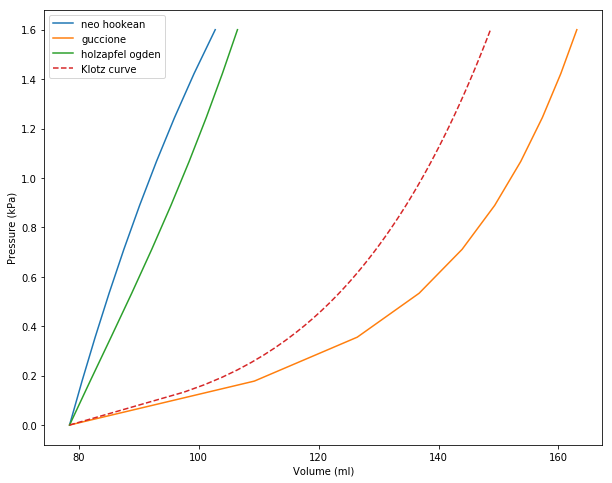

In [11]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8)

fig, ax = plt.subplots()
for material_model in ["neo_hookean", "guccione", "holzapfel_ogden"]:

    ax.plot(V[material_model], P[material_model],
            label=" ".join(material_model.split("_")))

vs, ps = klotz_curve()
ax.plot(vs, ps, linestyle="--", label='Klotz curve')
ax.legend(loc="best")
ax.set_xlabel('Volume (ml)')
ax.set_ylabel('Pressure (kPa)')
plt.show()